# Network inference of categorical variables: non-sequential data

In [1]:
import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline

import inference

In [2]:
# setting parameter:
np.random.seed(1)

n = 20 # number of positions
m = 3 # number of values at each position
l = int(4*((n*m)**2)) # number of samples
g = 2.

sp = 0.7 # degree of sparsity
nm = n*m

In [3]:
def itab(n,m):    
    i1 = np.zeros(n)
    i2 = np.zeros(n)
    for i in range(n):
        i1[i] = i*m
        i2[i] = (i+1)*m

    return i1.astype(int),i2.astype(int)

In [4]:
# generate coupling matrix w0:
def generate_interactions(n,m,g,sp):
    nm = n*m
    w = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))
    i1tab,i2tab = itab(n,m)

    for i in range(n):
        for j in range(n):
            if (j != i) and (np.random.rand() < sp): 
                w[i1tab[i]:i2tab[i],i1tab[j]:i2tab[j]] = 0.
                           
    for i in range(n):        
        i1,i2 = i1tab[i],i2tab[i]              
        w[i1:i2,:] -= w[i1:i2,:].mean(axis=0)            

    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
        w[i1:i2,i1:i2] = 0.   # no self-interactions

    for i in range(nm):
        for j in range(nm):
            if j > i: w[i,j] = w[j,i]  
        
    return w

In [5]:
i1tab,i2tab = itab(n,m)

In [6]:
w0 = generate_interactions(n,m,g,sp)

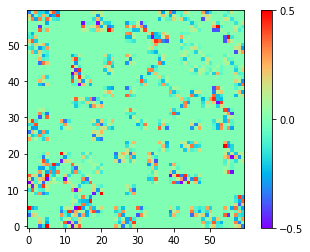

In [7]:
plt.imshow(w0,cmap='rainbow',origin='lower')
plt.clim(-0.5,0.5)
plt.colorbar(fraction=0.045, pad=0.05,ticks=[-0.5,0,0.5])
plt.show()
#print(w0)

In [8]:
# 2018.11.07: equilibrium
def generate_sequences_vp_tai(w,n,m,l):
    nm = n*m
    nrepeat = 10*n
    nrelax = m
    
    b = np.zeros(nm)

    s0 = np.random.randint(0,m,size=(l,n)) # integer values    
    enc = OneHotEncoder(n_values=m)
    s = enc.fit_transform(s0).toarray()   
    
    e_old = np.sum(s*(s.dot(w.T)),axis=1)
    
    for irepeat in range(nrepeat):
        for i in range(n):
            
            for irelax in range(nrelax):            
                r_trial = np.random.randint(0,m,size=l)        
                s0_trial = s0.copy()
                s0_trial[:,i] = r_trial

                s = enc.fit_transform(s0_trial).toarray()                                    
                e_new = np.sum(s*(s.dot(w.T)),axis=1)

                t = np.exp(e_new - e_old) > np.random.rand(l)
                s0[t,i] = r_trial[t]
                e_old[t] = e_new[t]
      
        if irepeat%(5*n) == 0: print(irepeat,np.mean(e_old))

    return enc.fit_transform(s0).toarray()

In [9]:
def generate_sequences_tai(w,n,m,l):
    i1tab,i2tab = itab(n,m)

    # initial s (categorical variables)
    s_ini = np.random.randint(0,m,size=(l,n)) # integer values
    #print(s_ini)

    # onehot encoder 
    enc = OneHotEncoder(n_values=m)
    s = enc.fit_transform(s_ini).toarray()
    #print(s)

    nrepeat = 500
    for irepeat in range(nrepeat):
        for i in range(n):
            i1,i2 = i1tab[i],i2tab[i]

            h = s.dot(w[i1:i2,:].T)              # h[t,i1:i2]
            h_old = (s[:,i1:i2]*h).sum(axis=1)   # h[t,i0]
            k = np.random.randint(0,m,size=l)

            for t in range(l):
                if np.exp(h[t,k[t]] - h_old[t]) > np.random.rand():
                    s[t,i1:i2] = 0.
                    s[t,i1+k[t]] = 1.
    return s   

In [10]:
#s = generate_sequences_vp_tai(w0,n,m,l)
s = generate_sequences_tai(w0,n,m,l)

[[0. 0. 1. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]
 ...
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]]


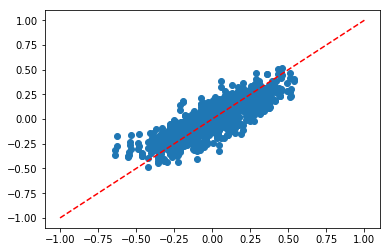

In [11]:
## 2018.11.07: for non sequencial data
def fit_additive(s,n,m):
    nloop = 10
    i1tab,i2tab = itab(n,m)

    nm = n*m
    nm1 = nm - m

    w_infer = np.zeros((nm,nm))

    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]

        # remove column i
        x = np.hstack([s[:,:i1],s[:,i2:]])
              
        x_av = np.mean(x,axis=0)
        dx = x - x_av
        c = np.cov(dx,rowvar=False,bias=True)
        c_inv = linalg.pinv(c,rcond=1e-15)

        #print(c_inv.shape)

        h = s[:,i1:i2].copy()
        for iloop in range(nloop):
            h_av = h.mean(axis=0)
            dh = h - h_av

            dhdx = dh[:,:,np.newaxis]*dx[:,np.newaxis,:]
            dhdx_av = dhdx.mean(axis=0)

            w = np.dot(dhdx_av,c_inv)
            
            #w = w - w.mean(axis=0) 

            h = np.dot(x,w.T)

            p = np.exp(h)
            p_sum = p.sum(axis=1)
            
            #p /= p_sum[:,np.newaxis]            
            for k in range(m):
                p[:,k] = p[:,k]/p_sum[:]
            
            h += s[:,i1:i2] - p
              
        w_infer[i1:i2,:i1] = w[:,:i1]
        w_infer[i1:i2,i2:] = w[:,i1:]
    
    return w_infer

w2 = fit_additive(s,n,m)

plt.plot([-1,1],[-1,1],'r--')
plt.scatter(w0,w2)

In [12]:
def fit_multiplicative(s,n,m,l):
    i1tab,i2tab = itab(n,m) 

    nloop = 10
    nm1 = nm - m

    w_infer = np.zeros((nm,nm))
    wini = np.random.normal(0.0,1./np.sqrt(nm),size=(nm,nm1))

    for i in range(n):

        i1,i2 = i1tab[i],i2tab[i]

        x = np.hstack([s[:,:i1],s[:,i2:]])
        y = s.copy()

        # covariance[ia,ib]
        cab_inv = np.empty((m,m,nm1,nm1))
        eps = np.empty((m,m,l))
        for ia in range(m):
            for ib in range(m):
                if ib != ia:
                    eps[ia,ib,:] = y[:,i1+ia] - y[:,i1+ib]

                    which_ab = eps[ia,ib,:] !=0.                    
                    xab = x[which_ab]          

                    # ----------------------------
                    xab_av = np.mean(xab,axis=0)
                    dxab = xab - xab_av
                    cab = np.cov(dxab,rowvar=False,bias=True)
                    cab_inv[ia,ib,:,:] = linalg.pinv(cab,rcond=1e-15)

        w = wini[i1:i2,:].copy()
        cost = np.full(nloop,100.) 
        for iloop in range(nloop):
            h = np.dot(x,w.T)
            
             # stopping criterion --------------------
            p = np.exp(h)
            p_sum = p.sum(axis=1)
            p /= p_sum[:,np.newaxis]

            cost[iloop] = ((y[:,i1:i2] - p[:,:])**2).mean()
            if iloop > 1 and cost[iloop] >= cost[iloop-1]: break
            
            for ia in range(m):
                wa = np.zeros(nm1)
                for ib in range(m):
                    if ib != ia:

                        which_ab = eps[ia,ib,:] !=0.

                        eps_ab = eps[ia,ib,which_ab]
                        xab = x[which_ab]

                        # ----------------------------
                        xab_av = np.mean(xab,axis=0)
                        dxab = xab - xab_av

                        h_ab = h[which_ab,ia] - h[which_ab,ib]                    
                        ha = np.divide(eps_ab*h_ab,np.tanh(h_ab/2.), out=np.zeros_like(h_ab), where=h_ab!=0)                        

                        dhdx = (ha - ha.mean())[:,np.newaxis]*dxab
                        dhdx_av = dhdx.mean(axis=0)

                        wab = cab_inv[ia,ib,:,:].dot(dhdx_av) # wa - wb

                        wa += wab
                w[ia,:] = wa/m

        w_infer[i1:i2,:i1] = w[:,:i1]
        w_infer[i1:i2,i2:] = w[:,i1:]

    return w_infer

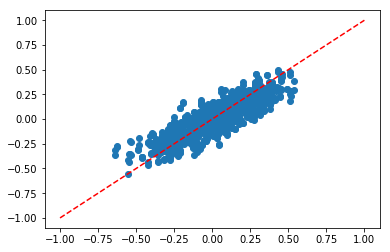

In [13]:
w_infer = fit_multiplicative(s,n,m,l)
plt.plot([-1,1],[-1,1],'r--')
plt.scatter(w0,w_infer)
#plt.scatter(w0[0:3,3:],w[0:3,:])